In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn import linear_model, metrics, ensemble
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import math

# Step 1: Importing Data

In [2]:
data = pd.read_csv("./chevron.csv")

In [3]:
print(data.head())
print(data.shape)

   Unnamed: 0    MSN StateCode  Year   Amount   State  CO2 Emissions (Mmt)  \
0           0  BDFDB        AK  2015     21.0  Alaska            35.027804   
1           1  BDPRP        AK  2015      4.0  Alaska            35.027804   
2           2  BFFDB        AK  2015     21.0  Alaska            35.027804   
3           3  BFPRP        AK  2015      4.0  Alaska            35.027804   
4           4  CLPRB        AK  2015  17747.0  Alaska            35.027804   

   TotalNumberofInvestments  TotalAmountofAssistance  
0                      16.0                3345612.0  
1                      16.0                3345612.0  
2                      16.0                3345612.0  
3                      16.0                3345612.0  
4                      16.0                3345612.0  
(7595, 9)


# Step 2: Cleaning Data (Dropping States and MSN's)

In [4]:
# Drop DC, US, Gulf of Mexico, Pacific
clean_df = data.query("StateCode != 'DC'").query("StateCode != 'US'").query("StateCode != 'X3'").query("StateCode != 'X5'")
print(clean_df.head())
print(clean_df.shape)
# print(clean_df.StateCode.unique())
# print(clean_df.StateCode.unique().size)

   Unnamed: 0    MSN StateCode  Year   Amount   State  CO2 Emissions (Mmt)  \
0           0  BDFDB        AK  2015     21.0  Alaska            35.027804   
1           1  BDPRP        AK  2015      4.0  Alaska            35.027804   
2           2  BFFDB        AK  2015     21.0  Alaska            35.027804   
3           3  BFPRP        AK  2015      4.0  Alaska            35.027804   
4           4  CLPRB        AK  2015  17747.0  Alaska            35.027804   

   TotalNumberofInvestments  TotalAmountofAssistance  
0                      16.0                3345612.0  
1                      16.0                3345612.0  
2                      16.0                3345612.0  
3                      16.0                3345612.0  
4                      16.0                3345612.0  
(7250, 9)


# Step 2.1: Convert all units to billion BTU

In [5]:
clean_df = clean_df
# Remove the BDFDB, BFFDB, BFPRP, EMFDB MSN's
clean_df = clean_df.query("MSN != 'BDFDB'").query("MSN != 'BFFDB'").query("MSN != 'BFPRP'").query("MSN != 'EMFDB'")
# print(clean_df.shape)
# Convert biodiesel to energy
biodiesel_converted = clean_df.query("MSN == 'BDPRP'")
# print(biodiesel_converted['Amount'])
# Scale the biodiesel by 5.46 (biodiesel: thousand barrels) (5.46: thousand btu/barrel)
# Total: Billion BTU
biodiesel_converted.loc[:, "Amount"] = biodiesel_converted.loc[:, "Amount"] * 5.46
# print(biodiesel_converted)
# Get all MSN's that are not BDPRP
non_bdprp = clean_df.query("MSN != 'BDPRP'")
# Concatenate the dataframes to get clean_df again
clean_df = pd.concat([non_bdprp, biodiesel_converted])
# print(clean_df.shape)

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
# Convert ethanol to energy
ethanol_converted = clean_df.query("MSN == 'ENPRP'")
# print(ethanol_converted['Amount'])
# Scale the biodiesel by 5.46 (ethanol: thousand barrels) (3.192: thousand btu/barrel)
# Total: Billion BTU
ethanol_converted.loc[:, "Amount"] = ethanol_converted.loc[:, "Amount"] * 3.192
# print(ethanol_converted['Amount'])
# Get all MSN's that are not ENPRP
non_enprp = clean_df.query("MSN != 'ENPRP'")
# Concatenate dataframes to get clean_df again
clean_df = pd.concat([non_enprp, ethanol_converted])
# print(clean_df.shape)

In [7]:
# Drop other MSN's that are either factors of conversion or are dependent on
# other factors
clean_df = clean_df.query("MSN != 'CLPRK'").query("MSN != 'CLPRP'").query("MSN != 'COPRK'") \
                    .query("MSN != 'PAPRP'").query("MSN != 'NGMPK'").query("MSN != 'NGMPP'")
# print(clean_df)


In [8]:
# Sort and reindex dataframe by original row indices
print(clean_df.sort_values('Unnamed: 0'))
clean_df.reset_index(drop=True, inplace=True)

      Unnamed: 0    MSN StateCode  Year    Amount    State  \
1              1  BDPRP        AK  2015     21.84   Alaska   
4              4  CLPRB        AK  2015  17747.00   Alaska   
9              9  ENPRP        AK  2015      0.00   Alaska   
10            10  GETCB        AK  2015    186.00   Alaska   
11            11  HYTCB        AK  2015  14621.00   Alaska   
...          ...    ...       ...   ...       ...      ...   
7579        7579  WDPRB        WY  2019   4969.00  Wyoming   
7580        7580  WDTCB        WY  2019   4969.00  Wyoming   
7581        7581  WSTCB        WY  2019      0.00  Wyoming   
7582        7582  WWPRB        WY  2019   4969.00  Wyoming   
7583        7583  WYTCB        WY  2019  37070.00  Wyoming   

      CO2 Emissions (Mmt)  TotalNumberofInvestments  TotalAmountofAssistance  
1               35.027804                      16.0                3345612.0  
4               35.027804                      16.0                3345612.0  
9               35

In [9]:
# print(clean_df)

In [10]:
# See how many zeroes there are in the dataframe
zeros_df = clean_df.query("Amount == 0")
# print(zeros_df)

In [11]:
# # Test Query Code
# test_query = clean_df.query("StateCode == 'AK' & Year == 2015")
# print(test_query)
# print(test_query.iloc[0, 8])
# print(type(test_query.iloc[0, 8]))

# # See how many features we have remaining
# print(clean_df.MSN.unique())
# print(clean_df.MSN.unique().size)

In [12]:
# # Find the unique states
# # alaska_df = clean_df.loc[clean_df["StateCode"] == "AK"]
# print(clean_df)
# print(clean_df.StateCode.unique())
# print(clean_df.StateCode.unique().size)

In [13]:
### Test on all states
# Generate all years and all states
all_years = [2015, 2016, 2017, 2018, 2019]
all_states = clean_df.StateCode.unique()

In [14]:
# print(clean_df)
# print(all_states)

# Step 3: Get the Feature Input matrix and Response Variable Matrix

# Step 3.1: Get Response Variable Matrix

In [15]:
# Create Response Variable y

num_datapoints = len(all_years) * len(all_states) 
num_cols = 1
# Initialize response var dataframe
y = pd.DataFrame(index=range(num_datapoints), columns=["TotalAmountofAssistance"])
investment_vals = []
# Iterate over all datapoints
for year in all_years:
    for state in all_states:
        # Query the state and year corresponding to the output
        state_query = "StateCode == " + "'" + str(state) + "'"
        year_query = "Year == " + str(year)
        investment_year_state = clean_df.query(year_query + " & " + state_query)
        # print("INVESTMENT YEAR QUERY DF")
        # print(investment_year.head())
        # print(investment_year.shape)
        # Get the investment value for this year & state (the very last column,
        # containing the Total Amount of Assistance)
        investment_year_val = investment_year_state.iloc[0, 8]
        investment_vals.append(investment_year_val)
for yIdx in range(num_datapoints):
    # Add the total amount of assistance to the response
    y.at[yIdx, "TotalAmountofAssistance"] = investment_vals[yIdx]
# y.at[0]["TotalAmountofAssistance"] = data["TotalAmountofAssistance"][0]
# print(y)
# y.at[1]["TotalAmountofAssistance"] = data["TotalAmountofAssistance"][1519]
# y.at[2]["TotalAmountofAssistance"] = data["TotalAmountofAssistance"][3038]
# y.at[3]["TotalAmountofAssistance"] = data["TotalAmountofAssistance"][4557]
# y.at[4]["TotalAmountofAssistance"] = data["TotalAmountofAssistance"][6076]
# for investment_idx in range(5):
#     print(investment_idx)
#     print(data["TotalAmountofAssistance"][3038])
#     row_idx = 1519 * investment_idx
#     y.at[investment_idx]["TotalAmountofAssistance"] = data["TotalAmountofAssistance"][row_idx]
# print(y)

# y.to_csv('assistance.csv')

In [16]:
# num_datapoints = len(all_years) * len(all_states) 
# num_features = 19

# all_msns = clean_df.MSN.unique()

# X = pd.DataFrame(index=range(num_datapoints), columns=all_msns)

# for yearIdx in range(len(all_years)):
#     for stateIdx in range(len(all_states)):
#         dataPtIdx = stateIdx * (yearIdx + 1)
#         # print(dataPtIdx)
#         curYear = all_years[yearIdx]
#         curState = all_states[stateIdx]
#         for msnIdx in range(len(all_msns)):
#             state_query = "StateCode == " + "'" + str(curState) + "'"
#             year_query = "Year == " + str(curYear)
#             msn_query = "MSN == " + "'" + str(all_msns[msnIdx]) + "'"
#             state_year_msn = clean_df.query(year_query + " & " + state_query + " & " + msn_query)
#             # print(state_year_msn)
#             amount_val = state_year_msn.iloc[0, 4]
#             X.at[dataPtIdx, all_msns[msnIdx]] = amount_val

# print(X)

In [17]:
# Test querying features

# all_msns = clean_df.MSN.unique()
# print(all_msns)
# X = pd.DataFrame(index=range(250), columns=all_msns)
# data_pt_idx= 0
# clean_df_row_idx = 0
# for year in all_years:
#     for state in all_states:
#         # data point
#         for feature_idx in range(19):
#             X.at[data_pt_idx, all_msns[feature_idx]] = clean_df.at[clean_df_row_idx, "Amount"]
#             clean_df_row_idx += 1
#         data_pt_idx += 1
# print(X)

# Step 3.2: Obtain Feature Input Matrix

In [18]:
# Create feature input matrix
# Note we are reading from 'flipped.csv', generated from a Java data processing
# pipeline from another teammate. All previous data processing has been implemented
# EXCEPT for scaling ENPRP and BDPRP to billions BTU.

X = pd.read_csv("flipped.csv")
# print(X)

sorted_X = X.sort_values(["Year", "State"], ascending=[True, True])
# print(sorted_X)

# Scale ENPRP and BDPRP.
sorted_X.loc[:, 'ENPRP'] *= 3.192
sorted_X.loc[:, 'BDPRP'] *= 5.46

# print(sorted_X)

# Remove state and year columns
sorted_X.drop(columns=['State', 'Year'], inplace=True)

# print(sorted_X.head())

# print(sorted_X)
# print(sorted_X.columns.size)

In [19]:
# print(alaska_df)

In [20]:
# numRows = 5
# numCols = 29

# x_comb = pd.DataFrame(index=range(numRows), columns=range(numCols))
# x_comb.columns = alaska_df["MSN"][0:numCols]

# # x = pd.DataFrame(index=range(numRows), columns=range(numCols))
# # x.columns = alaska_df["MSN"][0:numCols]
# # x_test = pd.DataFrame(index=range(4, 5), columns=range(numCols))
# # x_test.columns = alaska_df["MSN"][0:numCols]
# # print(x.columns)
# avgs = [[0] * numCols] * numRows
# for row_idx in range(int(alaska_df.shape[0])):
#     yr_idx = int(row_idx / numCols)
#     x_comb.at[yr_idx, x_comb.columns[row_idx % numCols]] = data.loc[1519 * yr_idx + row_idx]["Amount"]
#     # if row_idx < int(alaska_df.shape[0] * 4 / 5):
#     #     x.at[yr_idx, x.columns[row_idx % numCols]] = data.loc[1519 * yr_idx + row_idx]["Amount"]
#     # else:
#     #     x_test.at[yr_idx, x.columns[row_idx % numCols]] = data.loc[1519 * yr_idx + row_idx]["Amount"]

# norm_x_comb = (x_comb - x_comb.mean())/x_comb.std()

# norm_x = norm_x_comb.head(4)
# norm_x_test = norm_x_comb.tail(1)

# # print(x)
# # print(x_test)
# print(norm_x)
# print(norm_x_test)


# Step 3.3: Obtain testing data (features and assistance from 2020)

In [21]:
### Get testing data. Again, these are processed from a Java pipeline,
# missing a couple of data processing steps.
y_test = pd.read_csv("assistance_test.csv")
x_test = pd.read_csv("2020flipped.csv")

sorted_X_test = x_test.sort_values(["Year", "State"], ascending=[True, True])
# print(sorted_X)

sorted_X_test.loc[:, 'ENPRP'] *= 3.192
sorted_X_test.loc[:, 'BDPRP'] *= 5.46

## Remove state and year columns

# print(sorted_X)

sorted_X_test.drop(columns=['State', 'Year'], inplace=True)

print(sorted_X_test.head())
print(y_test.head())

     BDPRP     CLPRB    ENPRP     GETCB     HYTCB     NCPRB     NGMPB  \
0     0.00   15523.0     0.00     186.0   15475.0   16851.0  376283.0   
1  1567.02  313282.0     0.00     141.0  117112.0  120692.0  124831.0   
2  8479.38       0.0     0.00     808.0   39747.0   43767.0  489956.0   
3     0.00       0.0     0.00     345.0   56354.0  142484.0      68.0   
4  4892.16       0.0  8650.32  101857.0  187545.0  845282.0  192081.0   

      NUETB     PAPRB      REPRB     SOTCB      TEPRB      TETCB   WDEXB  \
0       0.0  932482.0    24682.0      62.0  1348969.0   640132.0     0.0   
1  454756.0   24528.0   288515.0    3439.0  1205912.0  1838656.0  5592.0   
2  157288.0   23578.0   111538.0    3212.0   782360.0  1034661.0     0.0   
3  329471.0      28.0   152046.0   80134.0   481613.0  1508154.0     0.0   
4  169773.0  814462.0  1013850.0  436716.0  2190166.0  6922764.0     0.0   

      WDPRB     WDTCB    WSTCB     WWPRB     WYTCB  
0    7423.0    7423.0    407.0    7831.0    1128.0 

In [22]:
y_test.drop(columns=y_test.columns[0], axis=1, inplace=True)
print(y_test.head())

   TotalAmountofAssistance
0                9567164.0
1                1174323.0
2               61208016.0
3               23756565.0
4               58722209.0


# Step 4: Perform regression analysis on data

# Step 4.1: Perform simple linear regression

In [23]:
### Drop wood energy production (another extraneous variable)
sorted_X_drop = sorted_X.drop(columns=['WDPRB'])
sorted_X_test_drop = sorted_X_test.drop(columns=['WDPRB'])

### Lin Reg Model
reg_drop = linear_model.LinearRegression()
reg_drop.fit(sorted_X_drop, y)

LinearRegression()

In [24]:
# Print model statistics
print(sorted_X_drop.columns)
print(reg_drop.coef_)
# reg_drop_coef_df = pd.DataFrame(reg_drop.coef_, columns=['AssistancePred'])
# print(reg_drop_coef_df)
print(reg_drop.intercept_)
print(reg_drop.score(sorted_X_drop, y))

Index(['BDPRP', 'CLPRB', 'ENPRP', 'GETCB', 'HYTCB', 'NCPRB', 'NGMPB', 'NUETB',
       'PAPRB', 'REPRB', 'SOTCB', 'TEPRB', 'TETCB', 'WDEXB', 'WDTCB', 'WSTCB',
       'WWPRB', 'WYTCB'],
      dtype='object')
[[-6.14656790e+02 -3.08993677e+06 -9.27032125e+02 -4.56783020e+05
  -4.56778040e+05  4.56299264e+05 -3.08993290e+06 -3.08993842e+06
  -3.08994309e+06 -3.08943032e+06 -4.56643965e+05  3.08993448e+06
   8.10309352e+00  6.42519838e+06  6.42067588e+06  6.41995886e+06
  -6.42131680e+06 -4.56793442e+05]]
[9209276.52562891]
0.19742345894701063


       PredictedAssistance
BDPRP        -6.146568e+02
CLPRB        -3.089937e+06
ENPRP        -9.270321e+02
GETCB        -4.567830e+05
HYTCB        -4.567780e+05
NCPRB         4.562993e+05
NGMPB        -3.089933e+06
NUETB        -3.089938e+06
PAPRB        -3.089943e+06
REPRB        -3.089430e+06
SOTCB        -4.566440e+05
TEPRB         3.089934e+06
TETCB         8.103094e+00
WDEXB         6.425198e+06
WDTCB         6.420676e+06
WSTCB         6.419959e+06
WWPRB        -6.421317e+06
WYTCB        -4.567934e+05


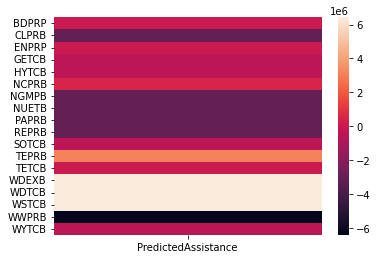

In [25]:
# Create heatmap to visualize output
reg_drop_coef_df = pd.DataFrame(reg_drop.coef_.transpose(), columns=['PredictedAssistance'])
reg_drop_coef_df.index = sorted_X_drop.columns
print(reg_drop_coef_df)
p1 = sns.heatmap(reg_drop_coef_df)

In [26]:
y_pred_drop = reg_drop.predict(sorted_X_test_drop)
# print(y_pred_drop)
# print(y_test)

y_pred_df = pd.DataFrame(y_pred_drop, columns=['PredictedAssistance'])
# print(y_pred_df)
# print(all_states)
# y_pred_df = y_pred_df.reindex(all_states)
# print(y_pred_df)

# Output the predictions to a CSV
y_pred_df.to_csv("LinearRegPredictions.csv")

In [27]:
# Compute mean squared error
mse = metrics.mean_squared_error(y_pred_drop, y_test)
# print(math.sqrt(mse))

# Step 4.2 Try other regression models (UNUSED IN FINAL PRESENTATION)

In [28]:
reg = linear_model.LinearRegression()
reg.fit(sorted_X, y)

LinearRegression()

In [29]:
lasso_reg = Lasso(1)

In [30]:
lasso_reg.fit(sorted_X, y)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e+17, tolerance: 5.035e+13
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)

In [31]:
lasso_train_score = lasso_reg.score(sorted_X, y)
print(lasso_train_score)

0.1913938906402758


In [32]:
y_pred_lasso = lasso_reg.predict(sorted_X_test)
print(y_pred_lasso)

[ 6.28008128e+06  2.47595029e+07  7.23373507e+06  3.18883211e+07
  8.47406309e+07  1.83937423e+07  5.59908506e+06  1.12340885e+07
  4.79993282e+07  8.55564880e+07  1.06501197e+07 -2.93103111e+05
  1.17165918e+07  1.61651065e+07  1.05468586e+07  1.31821433e+07
  1.52345455e+07  5.38795814e+07  1.02470337e+07  1.39255211e+07
  6.58171523e+05  2.23895053e+06  8.43113285e+06  1.29195691e+07
  4.75280385e+07  1.16675572e+07  1.26677558e+08 -7.20760757e+06
  1.11012465e+07  5.39321882e+06  1.75425739e+07  2.47327431e+06
  2.34118902e+07  1.34614269e+07  2.15969647e+07  1.36226926e+07
  1.38101632e+07  7.31705611e+06  9.02692406e+06  4.28068148e+07
  1.13647999e+07  2.32906077e+07  7.08482367e+07  1.76983260e+07
  4.17664542e+07  8.01834358e+06  2.18263733e+07  3.85506934e+06
  1.64453247e+07  5.13642480e+06]


In [33]:
print(lasso_reg.coef_)
print(lasso_reg.intercept_)

[-1.66133236e+02 -3.04511176e+00 -7.72338258e+01 -6.57342933e+01
 -2.64748517e+01  2.70051833e+01  6.43309891e-01 -8.95794657e+00
 -9.86714816e+00  2.59475621e+01  1.06246194e+02  1.20170588e+00
  7.92001511e+00  4.40448117e+03 -2.29125510e+02 -1.27158723e+01
 -8.90743258e+02  7.91958262e+01 -4.44933929e+01]
[9502865.62702641]


In [34]:
print(reg.intercept_)
print(reg.coef_)

[8848932.95507227]
[[ 5.64273389e+02 -1.57101119e+06  1.20344927e+03 -1.41370796e+05
  -1.41406391e+05  1.42115466e+05 -1.57100750e+06 -1.57101612e+06
  -1.57101750e+06 -1.57169610e+06 -1.41281992e+05  1.57100905e+06
   7.82328927e+00 -2.65199001e+07  3.49553490e+07 -2.65241724e+07
   8.43052956e+06 -8.43061306e+06 -1.41415516e+05]]


In [35]:
y_pred = reg.predict(sorted_X_test)
print(y_pred)
print(y_test)

[[-4.33020400e+06]
 [-1.03330080e+07]
 [ 7.11658245e+06]
 [ 3.00297071e+07]
 [ 8.59435946e+07]
 [ 8.95327864e+06]
 [ 5.04678280e+06]
 [ 1.07212881e+07]
 [ 4.81565702e+07]
 [ 8.41399954e+07]
 [ 1.82572662e+07]
 [ 2.41338449e+06]
 [ 1.11145715e+07]
 [ 1.62739063e+07]
 [ 1.12047407e+07]
 [ 2.22663062e+07]
 [ 1.62693483e+07]
 [ 5.08291914e+07]
 [ 1.78629382e+07]
 [ 1.30685582e+07]
 [ 8.67152049e+05]
 [ 5.13639080e+06]
 [ 9.58736445e+06]
 [ 1.32103001e+07]
 [ 1.13221420e+07]
 [ 5.98480166e+05]
 [ 1.22641695e+08]
 [-5.48347900e+06]
 [ 1.04617190e+07]
 [-1.93029445e+06]
 [ 1.49353918e+07]
 [ 1.60706807e+06]
 [ 2.58293400e+07]
 [ 1.22444801e+07]
 [ 1.98138317e+07]
 [ 1.48457573e+07]
 [ 1.26961874e+07]
 [-2.55032455e+06]
 [ 8.23504794e+06]
 [ 7.05127792e+06]
 [ 1.14040192e+07]
 [ 2.24490801e+07]
 [ 6.00356406e+07]
 [ 6.77896391e+06]
 [ 7.57952052e+07]
 [ 7.37442691e+06]
 [ 1.90488309e+07]
 [ 4.55344024e+06]
 [ 1.45327220e+07]
 [ 3.42095905e+06]]
    TotalAmountofAssistance
0                 956

In [36]:
print(reg.intercept_)
print(reg.coef_)
print(reg.score(sorted_X, y))
print(sorted_X.columns)

[8848932.95507227]
[[ 5.64273389e+02 -1.57101119e+06  1.20344927e+03 -1.41370796e+05
  -1.41406391e+05  1.42115466e+05 -1.57100750e+06 -1.57101612e+06
  -1.57101750e+06 -1.57169610e+06 -1.41281992e+05  1.57100905e+06
   7.82328927e+00 -2.65199001e+07  3.49553490e+07 -2.65241724e+07
   8.43052956e+06 -8.43061306e+06 -1.41415516e+05]]
0.21969392167899515
Index(['BDPRP', 'CLPRB', 'ENPRP', 'GETCB', 'HYTCB', 'NCPRB', 'NGMPB', 'NUETB',
       'PAPRB', 'REPRB', 'SOTCB', 'TEPRB', 'TETCB', 'WDEXB', 'WDPRB', 'WDTCB',
       'WSTCB', 'WWPRB', 'WYTCB'],
      dtype='object')


In [37]:
mse = metrics.mean_squared_error(y_pred, y_test)
print(mse)
print(math.sqrt(mse))

1054264821397483.4
32469444.426991407


In [38]:
mse_lasso = metrics.mean_squared_error(y_pred_lasso, y_test)
print(mse_lasso)
print(math.sqrt(mse_lasso))

873354863196210.8
29552577.9450154


In [39]:
### Gradient Boosting
params = {"n_estimators": 3, "max_depth": 3, "learning_rate": 1, "criterion": "squared_error"}
gradient_boosting_regressor_model = ensemble.GradientBoostingRegressor(**params)
gradient_boosting_regressor_model.fit(sorted_X, y)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(criterion='squared_error', learning_rate=1,
                          n_estimators=3)

In [40]:
print(gradient_boosting_regressor_model.score(sorted_X, y))

0.8594088494586949


In [41]:
y_pred_gradient = gradient_boosting_regressor_model.predict(sorted_X_test)
print(y_pred_gradient)
print(y_test)

[2.79923611e+06 1.08376685e+06 2.32641093e+07 4.25624095e+07
 4.56641589e+07 2.79923611e+06 2.79923611e+06 2.79923611e+06
 4.25624095e+07 2.20424347e+08 2.79923611e+06 2.79923611e+06
 2.79923611e+06 2.79923611e+06 2.79923611e+06 2.79923611e+06
 2.32641093e+07 2.32641093e+07 2.79923611e+06 2.79923611e+06
 2.79923611e+06 2.79923611e+06 2.79923611e+06 2.79923611e+06
 2.32641093e+07 2.79923611e+06 1.26884709e+08 2.79923611e+06
 2.79923611e+06 2.79923611e+06 2.42604689e+08 2.79923611e+06
 2.42771305e+07 2.79923611e+06 2.79923611e+06 2.79923611e+06
 1.14780389e+07 2.79923611e+06 2.79923611e+06 2.32641093e+07
 2.79923611e+06 2.79923611e+06 4.56641589e+07 2.79923611e+06
 2.32641093e+07 2.79923611e+06 5.90098551e+06 2.79923611e+06
 5.91571667e+05 1.35934600e+06]
    TotalAmountofAssistance
0                 9567164.0
1                 1174323.0
2                61208016.0
3                23756565.0
4                58722209.0
5                 6304206.0
6                  491729.0
7           

In [42]:
mse = metrics.mean_squared_error(y_pred_gradient, y_test)

print(mse)

print(math.sqrt(mse))


2712635931034190.5
52082971.60333875


In [43]:
### Polynomial Regression Model
poly = PolynomialFeatures(degree=2, include_bias=False)

In [44]:
poly_features = poly.fit_transform(sorted_X_drop)

In [45]:
poly_reg_model = linear_model.LinearRegression()

In [46]:
poly_reg_model.fit(poly_features, y)

LinearRegression()

In [47]:
print(poly_reg_model.score(poly_features, y))

0.9452227862433634


In [48]:
poly_test_features = poly.fit_transform(sorted_X_test_drop)
poly_reg_y_pred = poly_reg_model.predict(poly_test_features)

In [49]:
print(poly_reg_y_pred)
print(y_test)

[[ 1.83723727e+07]
 [-1.23020523e+08]
 [-9.30730734e+06]
 [ 1.30845973e+08]
 [ 3.60144565e+09]
 [-8.13498673e+07]
 [-1.08668593e+07]
 [ 1.13245035e+07]
 [-1.57853931e+08]
 [ 2.93541653e+08]
 [ 2.14523167e+07]
 [-1.45799908e+09]
 [ 1.28020656e+05]
 [-2.86731499e+08]
 [-3.00227819e+08]
 [-2.08087275e+08]
 [-7.80269873e+07]
 [ 9.09770447e+07]
 [-1.15009134e+06]
 [-1.36783153e+07]
 [-2.11351534e+06]
 [ 4.90647247e+07]
 [-3.43718123e+08]
 [ 2.47083727e+07]
 [-1.16080939e+08]
 [ 1.19631567e+07]
 [-3.53863915e+08]
 [ 1.54153749e+08]
 [-7.29894193e+07]
 [-2.46307633e+07]
 [ 2.46785487e+07]
 [-1.11496427e+08]
 [ 7.65927637e+08]
 [-2.22379243e+08]
 [-1.33516523e+08]
 [-1.40905707e+08]
 [-1.36549611e+08]
 [ 9.14223893e+08]
 [ 1.08514682e+07]
 [ 9.92161487e+07]
 [-1.61359339e+08]
 [-5.03019344e+05]
 [-2.14518367e+10]
 [-5.44330033e+07]
 [-1.86564913e+07]
 [ 1.01907167e+07]
 [-2.92113643e+08]
 [-3.92194353e+07]
 [-8.61176113e+07]
 [-7.24861233e+07]]
    TotalAmountofAssistance
0                 956

In [50]:
poly_reg_rmse = np.sqrt(metrics.mean_squared_error(y_test, poly_reg_y_pred))
print(poly_reg_rmse)

3096183506.0380974


In [51]:
### Interaction only
interaction_poly = PolynomialFeatures(interaction_only=True, include_bias=False)
interaction_features = interaction_poly.fit_transform(sorted_X_drop)

In [52]:
interaction_reg = linear_model.LinearRegression()
interaction_reg.fit(interaction_features, y)

LinearRegression()

In [53]:
print(interaction_reg.score(interaction_features, y))

0.8508430340641762


In [54]:
interaction_test_features = interaction_poly.fit_transform(sorted_X_test_drop)
interaction_reg_y_pred = interaction_reg.predict(interaction_test_features)

In [55]:
print(interaction_reg_y_pred)
print(y_test)

[[-7.25356334e+06]
 [-1.25671915e+08]
 [ 5.93714127e+07]
 [ 2.18958101e+08]
 [-6.20413054e+09]
 [ 5.25770447e+07]
 [ 1.56742447e+07]
 [ 1.30399795e+07]
 [-1.16735793e+07]
 [ 4.50884885e+08]
 [-2.17109173e+07]
 [ 3.35974165e+08]
 [ 1.98396687e+07]
 [-3.78414571e+08]
 [-3.88950251e+08]
 [-1.30542315e+08]
 [-6.24839473e+07]
 [ 1.34158357e+08]
 [-1.37359793e+07]
 [-2.16887633e+07]
 [ 4.12212656e+05]
 [-2.93096753e+07]
 [-7.15114033e+07]
 [ 1.95241967e+07]
 [-3.46202993e+07]
 [ 1.69474066e+06]
 [-2.88836331e+08]
 [ 7.07141327e+07]
 [ 2.27331605e+08]
 [-4.03508593e+07]
 [ 3.16222607e+07]
 [-4.98623793e+07]
 [ 5.55090127e+07]
 [-3.48484913e+07]
 [-5.36437553e+07]
 [-1.40424427e+08]
 [ 2.40811727e+07]
 [-1.07269355e+08]
 [ 5.71488916e+06]
 [ 4.58533327e+07]
 [ 7.28615247e+07]
 [-9.94664113e+07]
 [-1.03212987e+10]
 [-2.01121134e+06]
 [ 5.31227666e+06]
 [ 1.08391967e+07]
 [-2.26574571e+08]
 [ 3.67259666e+06]
 [ 1.48849941e+08]
 [ 6.86743247e+07]]
    TotalAmountofAssistance
0                 956

In [56]:
interaction_reg_rmse = np.sqrt(metrics.mean_squared_error(y_test, interaction_reg_y_pred))
print(interaction_reg_rmse)

1718642332.8903716


In [57]:
lasso_reg_drop = Lasso()
lasso_reg_drop.fit(sorted_X_drop, y)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e+17, tolerance: 5.035e+13
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [58]:
print(lasso_reg_drop.coef_)
print(lasso_reg_drop.intercept_)
print(lasso_reg_drop.score(sorted_X_drop, y))

[-1.66133145e+02 -3.04510876e+00 -7.72338829e+01 -6.57344977e+01
 -2.64749263e+01  2.70051903e+01  6.43309158e-01 -8.95796949e+00
 -9.86714498e+00  2.59475907e+01  1.06246166e+02  1.20170501e+00
  7.92001434e+00  4.17670683e+03 -2.40486148e+02 -8.89387685e+02
  7.78407660e+01 -4.44934329e+01]
[9502862.53902255]
0.19139417248137436


In [59]:
y_pred_lasso = lasso_reg_drop.predict(sorted_X_test_drop)
print(y_pred_lasso)
print(y_test)

[ 6.28007899e+06  2.47592659e+07  7.23373922e+06  3.18883093e+07
  8.47406416e+07  1.83937377e+07  5.59908552e+06  1.12340857e+07
  4.79993156e+07  8.55564428e+07  1.06501202e+07 -2.93099333e+05
  1.17165918e+07  1.61650845e+07  1.05468672e+07  1.31821399e+07
  1.52345481e+07  5.38795640e+07  1.02470425e+07  1.39255179e+07
  6.58184564e+05  2.23896264e+06  8.43113882e+06  1.29195718e+07
  4.75277800e+07  1.16675530e+07  1.26677468e+08 -7.20760660e+06
  1.11012406e+07  5.39321826e+06  1.75425704e+07  2.47327435e+06
  2.34118814e+07  1.34614290e+07  2.15969651e+07  1.36226926e+07
  1.38101645e+07  7.31705185e+06  9.02692282e+06  4.28065538e+07
  1.13647939e+07  2.32905947e+07  7.08482097e+07  1.76983221e+07
  4.17666613e+07  8.01834447e+06  2.18263644e+07  3.85508301e+06
  1.64453215e+07  5.13642845e+06]
    TotalAmountofAssistance
0                 9567164.0
1                 1174323.0
2                61208016.0
3                23756565.0
4                58722209.0
5                 

In [60]:
mse_lasso_drop = metrics.mean_squared_error(y_test, y_pred_lasso)
print(math.sqrt(mse_lasso_drop))

29552587.77832985


In [61]:
### Normalize the data
sorted_X_drop_norm = (sorted_X_drop - sorted_X_drop.mean()) / (sorted_X_drop.std())
sorted_X_test_drop_norm = (sorted_X_test_drop - sorted_X_test_drop.mean()) / (sorted_X_test_drop.std())

In [62]:
print(sorted_X_drop_norm)
print(sorted_X_test_drop_norm)

        BDPRP     CLPRB     ENPRP     GETCB     HYTCB     NCPRB     NGMPB  \
0   -0.533821 -0.340082 -0.438343 -0.256144 -0.316994 -0.552139 -0.180050   
5   -0.286166  0.024479 -0.438343 -0.259039  0.353660 -0.129830 -0.296753   
10   0.036771 -0.358594 -0.438343 -0.216122 -0.155234 -0.452494  0.202621   
15  -0.535228 -0.190499 -0.370271 -0.245913  0.084673 -0.009846 -0.404030   
20  -0.011071 -0.360708 -0.164050  6.994911  0.672832  2.516187 -0.244635   
..        ...       ...       ...       ...       ...       ...       ...   
229 -0.536635 -0.360708 -0.438343 -0.266246 -0.340555 -0.542311 -0.404088   
234  0.735413 -0.360708 -0.438343 -0.195017  4.657928  2.980924 -0.404088   
239 -0.084242 -0.360708  0.446472 -0.228540 -0.239785 -0.407149 -0.404088   
244 -0.536635  2.454478 -0.438343 -0.266053 -0.312039 -0.476336  1.124101   
249 -0.536635  5.251144 -0.438343 -0.225452 -0.367180 -0.374181  0.586663   

        NUETB     PAPRB     REPRB     SOTCB     TEPRB     TETCB     WDEXB  

In [63]:
linreg_norm = linear_model.LinearRegression()
linreg_norm.fit(sorted_X_drop_norm, y)

LinearRegression()

In [64]:
print(linreg_norm.coef_)
print(linreg_norm.intercept_)
print(linreg_norm.score(sorted_X_drop_norm, y))

[[-4.77001990e+06 -2.65862329e+12 -5.01644681e+07 -7.09907584e+09
  -5.26356076e+10  8.19507061e+10 -5.25318961e+12 -6.90304169e+11
  -3.79947443e+12 -7.01601861e+11 -2.16074802e+10  9.70324874e+12
   1.76166938e+07  2.52341125e+10  2.93722471e+11  8.41509453e+10
  -3.47969275e+11 -4.36717117e+10]]
[16605972.65616275]
0.19742345894631597


In [65]:
y_pred_norm = linreg_norm.predict(sorted_X_test_drop_norm)
print(y_pred_norm)
print(y_test)

[[ 4.52871808e+11]
 [-4.43074544e+11]
 [ 3.12812226e+11]
 [ 1.72159453e+11]
 [ 2.39864082e+11]
 [ 3.41144430e+11]
 [ 2.68296797e+11]
 [ 3.37535049e+11]
 [ 1.88415868e+11]
 [ 1.13533426e+11]
 [ 3.36736876e+11]
 [ 1.83125123e+11]
 [ 3.07278308e+11]
 [-1.34807140e+12]
 [-4.70979652e+11]
 [ 2.91225024e+11]
 [-6.55413996e+11]
 [ 6.37446151e+11]
 [ 3.37328199e+11]
 [ 2.19868741e+11]
 [ 3.17483086e+11]
 [ 1.91408083e+11]
 [ 2.21919520e+11]
 [ 2.75777911e+11]
 [ 2.51147186e+11]
 [-4.86346249e+11]
 [ 6.58407088e+10]
 [ 8.91443275e+10]
 [ 2.52582017e+11]
 [ 2.88462680e+11]
 [ 2.20752545e+11]
 [ 4.97286879e+11]
 [ 3.17769645e+11]
 [ 9.69521355e+10]
 [ 4.10332945e+11]
 [ 7.90399367e+11]
 [ 2.44441230e+11]
 [-6.80272935e+11]
 [ 3.37861434e+11]
 [ 5.58279229e+10]
 [ 2.88440887e+11]
 [ 1.26981354e+11]
 [ 2.04198445e+12]
 [-1.30293743e+11]
 [-2.46337804e+11]
 [ 3.31647955e+11]
 [ 9.72375293e+10]
 [ 2.65393714e+11]
 [-2.30913506e+12]
 [-6.04596139e+12]]
    TotalAmountofAssistance
0                 956

In [66]:
mse_norm = metrics.mean_squared_error(y_test, y_pred_norm)
print(math.sqrt(mse_norm))

1032310556577.1436


In [67]:
#### Attempt adding CO2 emissions and number of investments
# sorted_X_drop_add = sorted_X_drop.copy(deep=True)


In [68]:
### Replace zeros with the means for each column
sorted_X_drop_filled = sorted_X_drop.mask(sorted_X_drop==0).fillna(sorted_X_drop.mean())

In [69]:
# print(sorted_X_drop_filled.head())
# print(sorted_X_drop.head())
# print((sorted_X_drop == 0).sum(axis=1))

In [70]:
sorted_X_test_drop_filled = sorted_X_test_drop.mask(sorted_X_test_drop==0).fillna(sorted_X_test_drop.mean())

In [71]:
print((sorted_X_test_drop_filled == 0).sum(axis=1))

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
dtype: int64


In [72]:
linreg_drop_filled = linear_model.LinearRegression()
linreg_drop_filled.fit(sorted_X_drop_filled, y)

LinearRegression()

In [73]:
print(linreg_drop_filled.coef_)
print(linreg_drop_filled.intercept_)
print(linreg_drop_filled.score(sorted_X_drop_filled, y))

[[-6.78687076e+01  7.82218255e+00  1.77905493e+02  1.14757616e+02
   6.92068414e+01  7.16267985e+01  8.41314932e+00  9.94033165e+00
  -1.67220986e+00 -1.08839642e+02  1.81871744e+02 -7.41918723e+00
   8.59681088e+00  4.41167940e+03 -2.40256082e+02 -9.30243733e+02
   2.04892910e+02  7.71375869e+01]]
[-4736132.78732648]
0.19916387049455386


In [74]:
y_pred_drop_filled = linreg_drop_filled.predict(sorted_X_test_drop_filled)
print(y_pred_drop_filled)
print(y_test)

[[ 6.08547095e+06]
 [ 2.34385171e+07]
 [ 1.26487693e+07]
 [ 3.45003713e+07]
 [ 8.35617485e+07]
 [ 1.57661087e+07]
 [ 1.33969800e+07]
 [ 2.28906637e+07]
 [ 4.62142903e+07]
 [ 8.87184287e+07]
 [ 1.86526376e+07]
 [ 8.05300664e+06]
 [ 9.94765843e+06]
 [ 2.77031408e+07]
 [ 9.71598978e+06]
 [ 1.58900302e+07]
 [ 1.79890409e+07]
 [ 4.87691622e+07]
 [ 1.76506106e+07]
 [ 1.36049035e+07]
 [ 8.21789292e+06]
 [ 3.18727675e+06]
 [ 1.44566465e+07]
 [ 8.66302266e+06]
 [ 4.74650405e+07]
 [ 1.31935110e+07]
 [ 1.31882401e+08]
 [-9.10337233e+06]
 [ 1.05209597e+07]
 [ 1.28149608e+07]
 [ 2.65621077e+07]
 [ 1.61937350e+06]
 [ 2.72248349e+07]
 [ 1.31968685e+07]
 [ 1.77802500e+07]
 [ 1.68206158e+07]
 [ 1.15639630e+07]
 [ 5.96034130e+06]
 [ 1.72582018e+07]
 [ 5.10485462e+07]
 [ 1.07806048e+07]
 [ 1.31268647e+07]
 [ 7.15155979e+07]
 [ 1.85420176e+07]
 [ 3.67103881e+07]
 [ 1.57734832e+07]
 [ 2.81316478e+07]
 [ 7.29587111e+06]
 [ 1.85740444e+07]
 [ 5.64019825e+06]]
    TotalAmountofAssistance
0                 956

In [75]:
mse_drop_filled = metrics.mean_squared_error(y_test, y_pred_drop_filled)
print(math.sqrt(mse_drop_filled))

28641664.952540006


In [76]:
### Logistic Model
# logReg = linear_model.LogisticRegression()
# print(y.to_numpy())
# logReg.fit(sorted_X_drop, y.to_numpy())

[[3345612.0]
 [1864412.0]
 [13453887.0]
 [1724853.0]
 [30077512.0]
 [1658730.0]
 [1340702.0]
 [1452666.0]
 [3527420.0]
 [6155856.0]
 [1033143.0]
 [5552396.0]
 [1895904.0]
 [2533998.0]
 [2525723.0]
 [2548830.0]
 [315635700.0]
 [2312261.0]
 [4240538.0]
 [1890491.0]
 [2818563.0]
 [3049845.0]
 [3292766.0]
 [7036095.0]
 [3710526.0]
 [896759.0]
 [202376181.0]
 [420940.0]
 [3396859.0]
 [1371086.0]
 [1130951.0]
 [1126396.0]
 [790588.0]
 [5040800.0]
 [2513363.0]
 [1677872.0]
 [6478283.0]
 [4218295.0]
 [671306.0]
 [3065630.0]
 [3577721.0]
 [3275928.0]
 [2671308.0]
 [1243588.0]
 [2446464.0]
 [47317173.0]
 [1978193.0]
 [3755629.0]
 [491426.0]
 [249960.0]
 [2247734.0]
 [1206793.0]
 [4637664.0]
 [2053339.0]
 [59755992.0]
 [1800615.0]
 [962061.0]
 [502817.0]
 [4068360.0]
 [20155611.0]
 [429104.0]
 [4220545.0]
 [1317624.0]
 [1325335.0]
 [11391681.0]
 [1440764.0]
 [2257870.0]
 [1499474.0]
 [841616.0]
 [1349074.0]
 [795948.0]
 [1293489.0]
 [16796366.0]
 [10631411.0]
 [96309030.0]
 [2257495.0]
 [19047293

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'unknown'

In [79]:
## Test model with filled in data
### drop columns
#### note that emissions, numInvestments were added

data_filled = pd.read_csv("zeroless.csv")
# print(data_filled.head())
data_filled.drop(columns=[data_filled.columns[0]], inplace=True)
# print(data_filled.head())
data_filled.drop(columns=['State', 'WDPRB', 'Year', 'emissions', 'numInvestments'], inplace=True)
print(data_filled.head())

        BDPRP    CLPRB         ENPRP  GETCB    HYTCB  NCPRB     NGMPB  \
0    21.84000  17747.0  23720.058432    186  14621.0  16298  380887.0   
1    27.30000  13942.0  23814.938666    186  15317.0  17081  369865.0   
2    27.30000  14365.0  23910.198420    186  15143.0  16655  382940.0   
3    16.38000  13752.0  24005.839214    186  15151.0  16777  375279.0   
4  4164.53856  14867.0  24101.862571    186  14456.0  15951  364363.0   

           NUETB      PAPRB  REPRB  SOTCB    TEPRB   TETCB        WDEXB  \
0  168290.108000  1007501.0  23807      3  1429942  614242  1395.604000   
1  168963.268432  1026401.0  25155     14  1435363  593662  1401.186416   
2  169639.121506  1033270.0  23620     20  1454196  601492  1406.791162   
3  170317.677992   997415.0  24158     28  1410604  604644  1412.418326   
4  170998.948704   968358.0  22754     40  1370342  605689  1418.068000   

   WDTCB  WSTCB  WWPRB   WYTCB  assistance  
0   6865  622.0   7488  1488.0     3345612  
1   7636  412.0   80

In [80]:
# Extract the assistance
y_data_filled = data_filled.loc[:, 'assistance']
print(y_data_filled)
data_filled.drop(columns=['assistance'], inplace=True)
print(data_filled.head())

0       3345612
1       2247734
2      13509662
3      18236626
4      13734021
         ...   
245      249960
246     1359346
247      413987
248      573639
249      570570
Name: assistance, Length: 250, dtype: int64
        BDPRP    CLPRB         ENPRP  GETCB    HYTCB  NCPRB     NGMPB  \
0    21.84000  17747.0  23720.058432    186  14621.0  16298  380887.0   
1    27.30000  13942.0  23814.938666    186  15317.0  17081  369865.0   
2    27.30000  14365.0  23910.198420    186  15143.0  16655  382940.0   
3    16.38000  13752.0  24005.839214    186  15151.0  16777  375279.0   
4  4164.53856  14867.0  24101.862571    186  14456.0  15951  364363.0   

           NUETB      PAPRB  REPRB  SOTCB    TEPRB   TETCB        WDEXB  \
0  168290.108000  1007501.0  23807      3  1429942  614242  1395.604000   
1  168963.268432  1026401.0  25155     14  1435363  593662  1401.186416   
2  169639.121506  1033270.0  23620     20  1454196  601492  1406.791162   
3  170317.677992   997415.0  24158     28

In [81]:
linreg_filled = linear_model.LinearRegression()
linreg_filled.fit(data_filled, y_data_filled)

LinearRegression()

In [82]:
print(linreg_filled.coef_)
print(linreg_filled.intercept_)
print(linreg_filled.score(data_filled, y_data_filled))

[-6.42974123e+01  8.46192623e+00  7.24497456e+01  1.07046875e+02
  1.01666190e+02 -2.08876830e+01  7.86725036e+00  1.14403797e+01
 -1.17925200e+00 -5.61694030e+01  2.50854445e+02 -7.43329662e+00
  8.21199227e+00  3.17572439e+03 -1.36646069e+03 -2.01484733e+03
  1.27475431e+03  1.21103831e+02]
-5378039.652446944
0.19973678325471178


In [83]:
y_pred_filled = linreg_filled.predict(sorted_X_test_drop)

In [84]:
print(y_pred_filled)
print(y_test)

[-9.13020953e+06  1.27085517e+07 -7.63160337e+06  2.11840553e+07
  7.80095331e+07  3.90109974e+06 -7.53751978e+06 -3.56865204e+06
  3.73098489e+07  7.31890616e+07 -4.00917866e+06 -9.65324848e+06
 -3.79415117e+06  1.91761548e+07 -2.06876656e+06  4.82673261e+06
  1.41950842e+06  3.62489323e+07 -4.65160631e+06  1.13810447e+06
 -1.54724048e+07 -8.84477797e+06 -3.33394665e+06 -2.25085539e+05
  3.38808983e+07 -2.36048438e+06  1.18177545e+08 -1.97804348e+07
 -2.40738199e+06 -8.72646028e+06  6.42045454e+06 -1.31584395e+07
  1.01042423e+07  1.04458644e+06  5.83223911e+06  7.41650402e+05
 -2.95934635e+06 -6.61325064e+06 -5.80536708e+06  3.38438135e+07
 -3.67059662e+06  1.13953288e+07  7.18565621e+07  3.86299855e+06
  3.07322466e+07 -7.23368166e+06  1.83999033e+06 -1.13145392e+07
  2.51523438e+06  4.46733015e+05]
    TotalAmountofAssistance
0                 9567164.0
1                 1174323.0
2                61208016.0
3                23756565.0
4                58722209.0
5                 

In [85]:
new_mse_drop_filled = metrics.mean_squared_error(y_test, y_pred_filled)
print(math.sqrt(new_mse_drop_filled))

30696653.460787777
